In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch import einsum
from tqdm import tqdm
from einops import rearrange, repeat
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

In [2]:
class EEGFeatureMapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_list = []
        self.labels = []
        
        self._validate_and_collect()

    def _validate_and_collect(self):
        for fname in os.listdir(self.root_dir):
            if not fname.endswith('.npz'):
                continue
                
            fpath = os.path.join(self.root_dir, fname)
            try:
                with np.load(fpath) as data:
                    features = data['features']
                    label = data['label'][0]
                    
                    if features.shape == (50, 1, 64, 64) and not np.isnan(features).any():
                        self.file_list.append(fpath)
                        self.labels.append(label)
            except:
                print(f"Skipping corrupted file: {fname}")

        self.labels = np.array(self.labels)
        self.class_counts = np.bincount(self.labels, minlength=6)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        with np.load(self.file_list[idx]) as data:
            features = data['features'].astype(np.float32)
            label = data['label'][0]

        features = (features - features.mean()) / (features.std() + 1e-8)
            
        return torch.from_numpy(features), torch.tensor(label, dtype=torch.long)

In [3]:
class PatchEmbedding3D(nn.Module):
    
    def __init__(self, in_channels:int, embedding_dim:int, patch_size:int):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv3d(
            in_channels, embedding_dim,
            kernel_size=(1, patch_size, patch_size),
            stride=(1, patch_size, patch_size)
        )
        
    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4).contiguous()   
        x = self.proj(x)
        B, D, T, H, W = x.shape
        x = rearrange(x, 'b d t h w -> b (t h w) d', b = B, d = D, t = T, h = H, w = W)
        return x              

class LayerNormalization(nn.Module):

    def __init__(self, embedding_dim: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(embedding_dim)) 
        self.bias = nn.Parameter(torch.zeros(embedding_dim)) 

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True) 
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

class FeedForwardBlock(nn.Module):
    
    def __init__(self, embedding_dim: int, mlp_size: int, dropout: float):
        super().__init__()
        self.linear_1 = nn.Linear(embedding_dim, mlp_size) 
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(mlp_size, embedding_dim) 

    def forward(self, x):
        return self.linear_2(self.dropout(F.gelu(self.linear_1(x))))

class Attention(nn.Module):

    def __init__(self, embedding_dim: int, num_heads: int):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.d_k = embedding_dim // num_heads
        assert embedding_dim % num_heads == 0, "d_model must be divisible by h"
        self.qkv = nn.Linear(embedding_dim, embedding_dim * 3, bias=False)
        self.w_o = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, D // self.num_heads).permute(2, 0, 3, 1, 4)
        query, key, value = qkv[0], qkv[1], qkv[2]
        attention = (query @ key.transpose(-2, -1)) / math.sqrt(self.d_k)
        attention = F.softmax(attention, dim=-1)
        x = (attention @ value).transpose(1, 2).reshape(B, N, D)
        return self.w_o(x)       

class EncoderBlock(nn.Module):
    def __init__(self, embedding_dim:int, num_heads: int, mlp_size: int, batch_size: int, 
                 num_frames: int, num_patches: int, dropout: float):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.mlp_size = mlp_size
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.num_patches = num_patches
        self.dropout = nn.Dropout(dropout)
        self.norm1 = LayerNormalization(embedding_dim)
        self.spatial_attention = Attention(embedding_dim, num_heads)
        self.temporal_attention = Attention(embedding_dim, num_heads)
        self.dropout_1 = nn.Dropout(dropout)
        self.norm2 = LayerNormalization(embedding_dim)  
        self.ffn = FeedForwardBlock(embedding_dim, mlp_size, dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x): 
        B = self.batch_size
        T = self.num_frames
        S = self.num_patches
        residual = x
        x = self.norm1(x)
        X = x[:,1:,:]
        init_cls_token = x[:,0,:].unsqueeze(1)
        
        # Spatial Attention
        t_cls_token = init_cls_token.repeat(1, T, 1)
        t_cls_token = rearrange(t_cls_token, 'b t m -> (b t) m', b = B, t = T).unsqueeze(1)
        xs = rearrange(X, 'b (s t) d -> (b t) s d', b = B, t = T, s = S)
        xs = torch.cat((t_cls_token, xs), 1)
        spatial_attention = self.spatial_attention(xs)
        t_cls_token = spatial_attention[:,0,:]
        t_cls_token = rearrange(t_cls_token, '(b t) m -> b t m', b = B, t = T)
        t_cls_token = torch.mean(t_cls_token, 1, True)
        spatial_attention = spatial_attention[:,1:,:]
        spatial_attention = rearrange(spatial_attention, '(b t) s d -> b (t s) d', b = B, t = T, s = S)
        spatial_attention = torch.cat((t_cls_token, spatial_attention), 1)

        spatial_attention = spatial_attention + residual
        
        # Temporal Attention
        # X = spatial_attention[:,1:,:]
        init_cls_token = spatial_attention[:,0,:].unsqueeze(1)
        s_cls_token = init_cls_token.repeat(1, S, 1)
        s_cls_token = rearrange(s_cls_token, 'b s m -> (b s) m', b = B, s = S).unsqueeze(1)
        xt = rearrange(spatial_attention[:,1:,:], 'b (s t) d -> (b s) t d', b = B, s = S, t = T)
        xt = torch.cat((s_cls_token, xt), 1)
        temporal_attention = self.temporal_attention(xt)
        s_cls_token = temporal_attention[:,0,:]
        s_cls_token = rearrange(s_cls_token, '(b s) m -> b s m', b = B, s = S)
        s_cls_token = torch.mean(s_cls_token, 1, True)
        temporal_attention = temporal_attention[:,1:,:]
        temporal_attention = rearrange(temporal_attention, '(b s) t d -> b (t s) d', b = B, t = T, s = S)
        temporal_attention = torch.cat((s_cls_token, temporal_attention),1)

        attn_out = spatial_attention + temporal_attention
        # attn_out = combined + residual
        attn_out = self.dropout_1(attn_out)
        out = attn_out + self.dropout_2(self.ffn(self.norm2(attn_out)))
        return out

class Encoder(nn.Module):
    def __init__(self, embedding_dim: int, num_layers: int, num_heads: int, mlp_size: int, 
                 batch_size: int, num_frames: int, num_patches: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderBlock(
                embedding_dim = embedding_dim,
                num_heads = num_heads,
                mlp_size = mlp_size,
                batch_size = batch_size,
                num_frames = num_frames,
                num_patches = num_patches,
                dropout = dropout
            ) for _ in range(num_layers)
        ])
        self.norm = LayerNormalization(embedding_dim) 

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [4]:
class EEGSpatioTemporalTransformer(nn.Module):
    def __init__(self, 
                 num_classes:int = 6,
                 num_frames:int = 50,
                 feature_size:int = 64, # spatial_size
                 in_channels:int = 1,
                 patch_size:int = 16,
                 batch_size:int = 16,
                 embed_dim:int = 256,
                 num_heads:int = 8,
                 num_layers:int = 4,
                 mlp_ratio:float = 4.,
                 dropout:float = 0.1,
                 embed_dropout:float = 0.1):
        super().__init__()
        
        self.patch_embedding = PatchEmbedding3D(
            in_channels = in_channels, 
            embedding_dim = embed_dim, 
            patch_size = patch_size
        )
        
        self.num_patches = (feature_size // patch_size) ** 2
        self.num_tokens = num_frames * self.num_patches
        self.batch_size = batch_size
        self.num_frames = num_frames

        self.class_embedding = nn.Parameter(data = torch.zeros(1, 1, embed_dim), requires_grad = True)
        
        self.positional_embedding = nn.Parameter(data = torch.randn(1, self.num_tokens + 1, embed_dim), requires_grad = True)

        self.embedding_dropout = nn.Dropout(embed_dropout)

        self.transformer_encoder = Encoder(
            embedding_dim = embed_dim,
            num_layers = num_layers,
            num_heads = num_heads,
            mlp_size = int(embed_dim * mlp_ratio),
            batch_size = batch_size,
            num_frames = num_frames,
            num_patches = self.num_patches,
            dropout = dropout
        )

        self.classifier = nn.Linear(in_features = embed_dim, out_features = num_classes)
                
        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.positional_embedding, std=0.02)
        nn.init.trunc_normal_(self.class_embedding, std=0.02)
        # nn.init.constant_(self.classifier.weight, 0)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.constant_(self.classifier.bias, 0)

    def forward(self, x):        

        x = self.patch_embedding(x)  
        cls_token = self.class_embedding.expand(self.batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.positional_embedding
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:,0,:])
        return x

In [5]:
class EEGTrainer:
    def __init__(self, config):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.config = config
        
        self.train_dataset = EEGFeatureMapDataset(config['train_dir'])
        self.test_dataset = EEGFeatureMapDataset(config['test_dir'])
        
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        self.model = EEGSpatioTemporalTransformer(
            num_classes=config['num_classes'],
            num_frames=50,
            feature_size=64,
            patch_size=16,
            batch_size = config['batch_size'],
            embed_dim=256,
            num_heads=8,
            num_layers=4
        ).to(self.device)
        
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['lr'],
            weight_decay=config['weight_decay']
        )
        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=config['lr'],
            total_steps=config['epochs'] * len(self.train_loader)
        )
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        self.best_acc = 0.0
        self.train_loss = []
        self.test_loss = []
        self.train_acc = []
        self.test_acc = []

    def train_epoch(self):
        self.model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(self.train_loader, desc="Training"):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            with torch.cuda.amp.autocast():
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()
            
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        return epoch_loss/len(self.train_loader), 100.*correct/total

    def validate(self):
        self.model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(self.test_loader, desc="Test"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=[f'Class_{i}' for i in range(6)]))
        
        plt.figure(figsize=(10,8))
        sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d')
        plt.title("Confusion Matrix")
        plt.show()
        
        return test_loss/len(self.test_loader), 100.*correct/total

    def train(self):
        for epoch in range(self.config['epochs']):
            train_loss, train_acc = self.train_epoch()
            test_loss, test_acc = self.validate()
            # torch.save(self.model.state_dict(), f"/kaggle/working/model_epoch_{epoch}.pth")
            
            if test_acc > self.best_acc:
                self.best_acc = test_acc
                torch.save(self.model.state_dict(), f"/kaggle/working/best_model_epoch_{epoch}.pth")
            
            self.train_loss.append(train_loss)
            self.test_loss.append(test_loss)
            self.train_acc.append(train_acc)
            self.test_acc.append(test_acc)
            
            print(f"Epoch {epoch+1}/{self.config['epochs']}")
            print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
            print(f"Test Loss: {test_loss:.4f} | Acc: {test_acc:.2f}%")
            
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(self.train_loss, label='Train')
        plt.plot(self.test_loss, label='Validation')
        plt.title("Loss Curve")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(self.train_acc, label='Train')
        plt.plot(self.test_acc, label='Validation')
        plt.title("Accuracy Curve")
        plt.legend()
        plt.show()

Training:   0%|          | 0/3600 [00:00<?, ?it/s]/tmp/ipykernel_31/3670898527.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Test: 100%|██████████| 900/900 [00:23<00:00, 38.38it/s]



Classification Report:
              precision    recall  f1-score   support

     Class_0       0.20      0.00      0.00      1200
     Class_1       0.24      0.91      0.38      1200
     Class_2       0.33      0.24      0.28      1200
     Class_3       0.20      0.11      0.14      1200
     Class_4       0.30      0.16      0.21      1200
     Class_5       0.29      0.11      0.16      1200

    accuracy                           0.26      7200
   macro avg       0.26      0.26      0.20      7200
weighted avg       0.26      0.26      0.20      7200



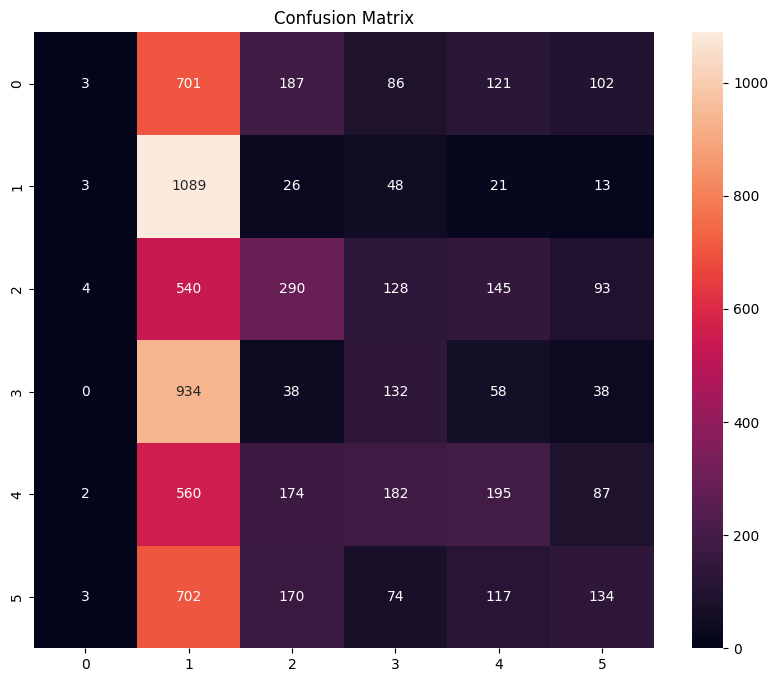

Epoch 1/30
Train Loss: 1.8208 | Acc: 21.61%
Test Loss: 1.7566 | Acc: 25.60%


Training:   0%|          | 0/3600 [00:00<?, ?it/s]/tmp/ipykernel_31/3670898527.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Test: 100%|██████████| 900/900 [00:21<00:00, 41.95it/s]



Classification Report:
              precision    recall  f1-score   support

     Class_0       0.24      0.51      0.32      1200
     Class_1       0.30      0.86      0.44      1200
     Class_2       0.61      0.06      0.10      1200
     Class_3       0.26      0.03      0.06      1200
     Class_4       0.32      0.20      0.24      1200
     Class_5       0.56      0.06      0.11      1200

    accuracy                           0.29      7200
   macro avg       0.38      0.29      0.21      7200
weighted avg       0.38      0.29      0.21      7200



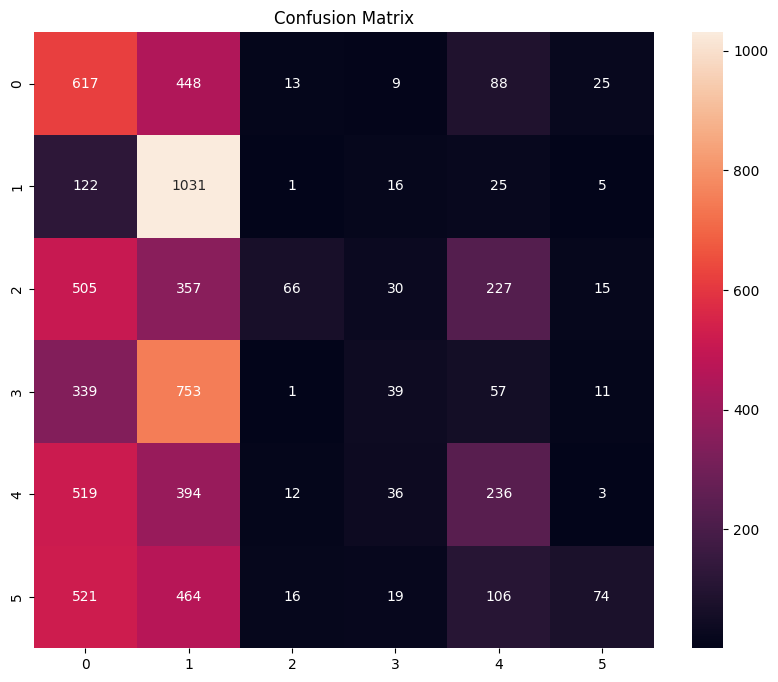

Epoch 2/30
Train Loss: 1.7030 | Acc: 29.51%
Test Loss: 1.8495 | Acc: 28.65%


Training:   0%|          | 0/3600 [00:00<?, ?it/s]/tmp/ipykernel_31/3670898527.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Test: 100%|██████████| 900/900 [00:36<00:00, 24.38it/s]



Classification Report:
              precision    recall  f1-score   support

     Class_0       0.30      0.49      0.37      1200
     Class_1       0.67      0.43      0.52      1200
     Class_2       0.27      0.61      0.38      1200
     Class_3       0.43      0.10      0.16      1200
     Class_4       0.35      0.26      0.30      1200
     Class_5       0.32      0.15      0.21      1200

    accuracy                           0.34      7200
   macro avg       0.39      0.34      0.32      7200
weighted avg       0.39      0.34      0.32      7200



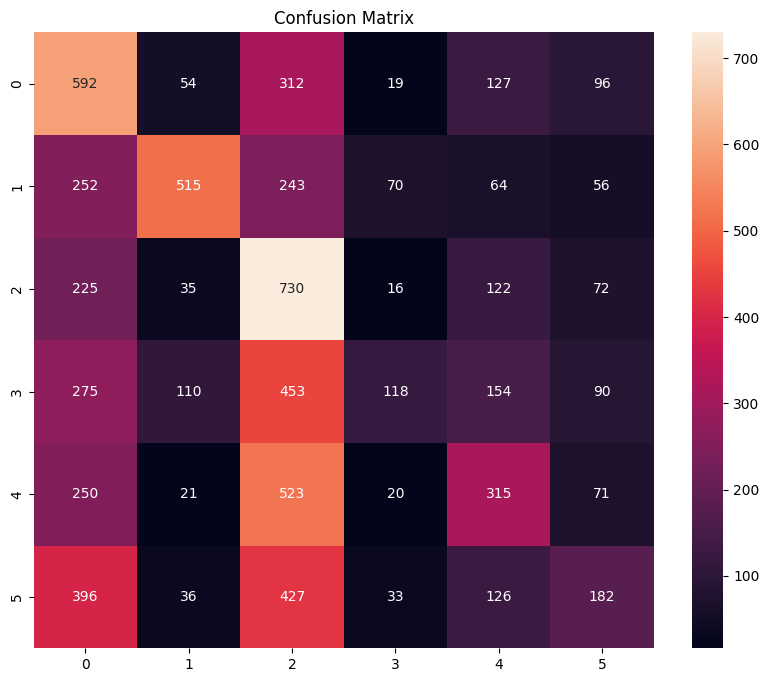

Epoch 3/30
Train Loss: 1.6550 | Acc: 33.40%
Test Loss: 1.6451 | Acc: 34.06%


Training:   0%|          | 0/3600 [00:00<?, ?it/s]/tmp/ipykernel_31/3670898527.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Test: 100%|██████████| 900/900 [00:23<00:00, 38.36it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13


Classification Report:
              precision    recall  f1-score   support

     Class_0       0.17      0.00      0.01      1200
     Class_1       0.23      0.83      0.37      1200
     Class_2       0.00      0.00      0.00      1200
     Class_3       0.17      0.39      0.24      1200
     Class_4       0.24      0.04      0.07      1200
     Class_5       0.63      0.01      0.02      1200

    accuracy                           0.21      7200
   macro avg       0.24      0.21      0.12      7200
weighted avg       0.24      0.21      0.12      7200



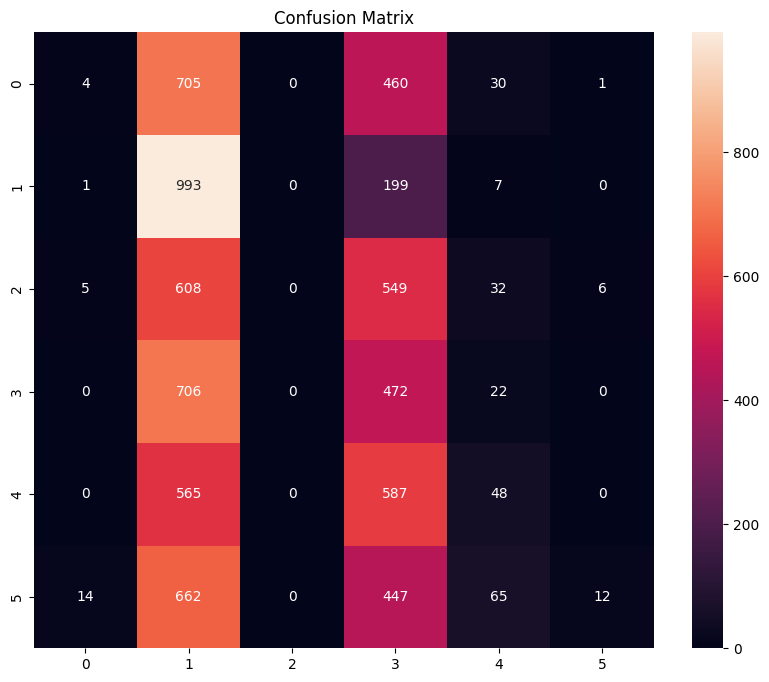

Epoch 4/30
Train Loss: 1.6383 | Acc: 34.09%
Test Loss: 1.7880 | Acc: 21.24%


Training:   0%|          | 0/3600 [00:00<?, ?it/s]/tmp/ipykernel_31/3670898527.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Test: 100%|██████████| 900/900 [00:23<00:00, 38.98it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13


Classification Report:
              precision    recall  f1-score   support

     Class_0       0.17      1.00      0.29      1200
     Class_1       0.00      0.00      0.00      1200
     Class_2       0.00      0.00      0.00      1200
     Class_3       0.00      0.00      0.00      1200
     Class_4       0.00      0.00      0.00      1200
     Class_5       0.00      0.00      0.00      1200

    accuracy                           0.17      7200
   macro avg       0.03      0.17      0.05      7200
weighted avg       0.03      0.17      0.05      7200



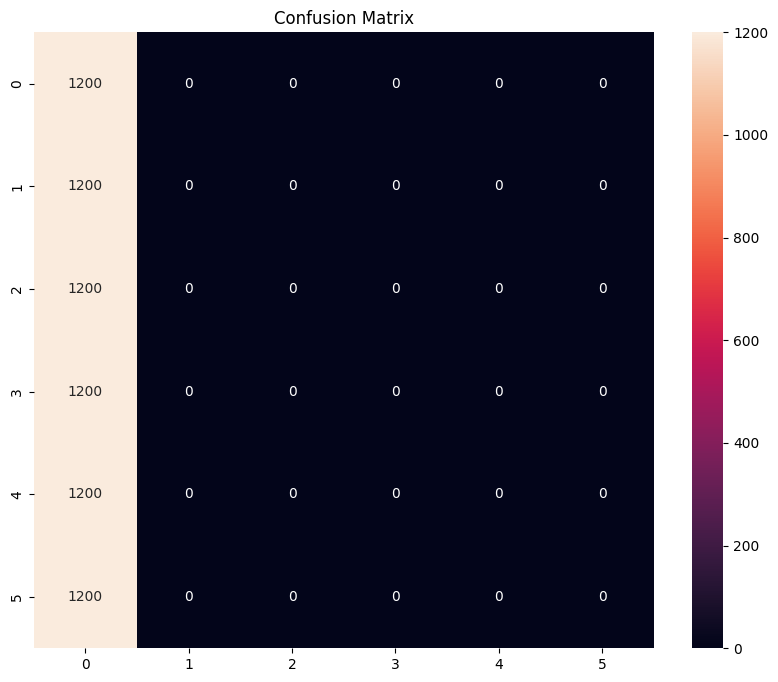

Epoch 5/30
Train Loss: nan | Acc: 16.82%
Test Loss: nan | Acc: 16.67%


Training:   0%|          | 0/3600 [00:00<?, ?it/s]/tmp/ipykernel_31/3670898527.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:   1%|▏         | 53/3600 [00:03<03:50, 15.41it/s]

In [ ]:
config = {
    'train_dir': '/kaggle/input/eeg-spatio-temporal-feature-map-dataset/Train',
    'test_dir': '/kaggle/input/eeg-spatio-temporal-feature-map-dataset/Test',
    'num_classes': 6,
    'batch_size': 8,
    'lr': 6e-4,
    'weight_decay': 0.05,
    'epochs': 30
}

trainer = EEGTrainer(config)
trainer.train()